In [8]:
############
# PACKAGES #
############

%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
theano.config.exception_verbosity='high'
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import cPickle as pickle
import gzip
import os
import sys
import timeit
import pandas as pd

import cartpole_lib as cp

import nnet_lib as nnet


# An example of a simple policy for a single cart/pole mass

In [72]:
#################
# GENERATE DATA #
#################

dt, eps = 0.1, 0.1
Q = np.eye(6)
R = np.eye(1)

xref1 = np.array([0,np.pi,0,0,10,1])
uref = 0.
A1, B1, c1 = cp.linearize_cartpole_ext(xref1, uref, dt, eps)
K1, P1, Quu1 = cp.lqr_infinite_horizon(A1, B1, Q, R)

x1 = np.array([0, np.pi - np.pi/4, 0, 0, 10, 1])
x2 = np.array([0, np.pi + np.pi/4, 0, 0, 10, 1])

Quu0 = np.array([[0.]])

tr_x, tr_u, val_x, val_u, te_x, te_u = cp.gen_train_data([x1, x2], [K1, K1], [Quu1, Quu1], 
                                                         num_traj=50, noisy_mass_est=0.05, traj_size=500)


In [73]:
df = pd.DataFrame(tr_x)

In [74]:
df.mean()

0          NaN
1          NaN
2          NaN
3          NaN
4    10.698094
5     0.948045
dtype: float64

In [6]:
####################
# TRAIN BASIC NNET #
####################

input1, policy1, tr_loss1, val_loss1, test_loss1 = nnet.train_NN(
    tr_x, tr_u, val_x, val_u, te_x, te_u, # Training, validiation, and test data
    n_layers=1, n_hidden=15, # Nnet parameters
    learning_rule='adagrad', learning_rate=1.0, L1_reg=0.0, L2_reg=0.00001, batch_size=50, rho=0.9, #SGD parameters
    n_epochs=100, print_interval=5, random_order=True # Training parameters
)

... building the model
... training
epoch 5, minibatch 400/400, validation error 152.363436, test error of best model 155.189990
epoch 10, minibatch 400/400, validation error 69.463424, test error of best model 81.084526
epoch 15, minibatch 400/400, validation error 32.744904, test error of best model 50.901224
epoch 20, minibatch 400/400, validation error 21.076555, test error of best model 42.601297
epoch 25, minibatch 400/400, validation error 9.726372, test error of best model 32.830809
epoch 30, minibatch 400/400, validation error 7.040158, test error of best model 30.906823
epoch 35, minibatch 400/400, validation error 6.328752, test error of best model 30.586372
epoch 40, minibatch 400/400, validation error 6.036291, test error of best model 30.505669
epoch 45, minibatch 400/400, validation error 5.827494, test error of best model 30.406900
epoch 50, minibatch 400/400, validation error 5.715784, test error of best model 30.388248
epoch 55, minibatch 400/400, validation error 5.6

Final position for starting position x1
[ -2.87231555   3.1328258    0.2382742    0.02342286  10.           1.        ]
Final position for starting position x2
[  2.07239899e+00   3.14232384e+00   1.80752219e-01  -8.48663257e-05
   1.00000000e+01   1.00000000e+00]


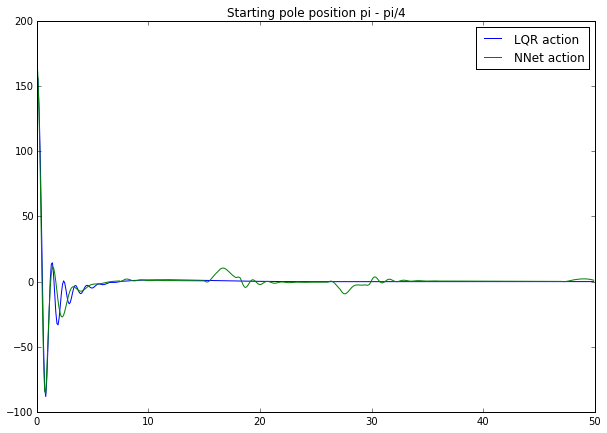

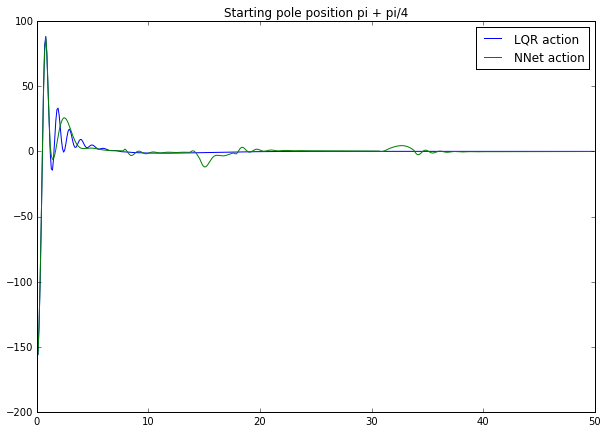

In [7]:
####################
# TEST NNET POLICY #
####################

feed_forward = theano.function(
    inputs=[input1],
    outputs=policy1.output)

x_ref = np.array([0, np.pi, 0, 0, 10, 1])

# First starting position
x_sim1 = np.zeros([6,500])
x_sim1[:,0] = x1

u_sim1 = np.zeros([500,])
u_sim1[0] = feed_forward(x_sim1[:,0].reshape([1,6]))

for t in range(499):
    x_sim1[:,t+1] = cp.sim_cartpole_ext(x_sim1[:,t], u_sim1[t], dt)
    u_sim1[t+1] = feed_forward(x_sim1[:,t+1].reshape([1,6]))

x_lqr1 = np.zeros([6,500])
x_lqr1[:,0] = x1

u_lqr1 = np.zeros([500,])
u_lqr1[0] = np.dot(K1, x_lqr1[:,0] - x_ref)
for t in range(499):
    x_lqr1[:,t+1] = cp.sim_cartpole_ext(x_lqr1[:,t], u_lqr1[t], dt)
    u_lqr1[t+1] = np.dot(K1, x_lqr1[:,t] - x_ref)

# Second starting position
x_sim2 = np.zeros([6,500])
x_sim2[:,0] = x2

u_sim2 = np.zeros([500,])
u_sim2[0] = feed_forward(x_sim2[:,0].reshape([1,6]))

for t in range(499):
    x_sim2[:,t+1] = cp.sim_cartpole_ext(x_sim2[:,t], u_sim2[t], dt)
    u_sim2[t+1] = feed_forward(x_sim2[:,t+1].reshape([1,6]))

x_lqr2 = np.zeros([6,500])
x_lqr2[:,0] = x2

u_lqr2 = np.zeros([500,])
u_lqr2[0] = np.dot(K1, x_lqr2[:,0] - x_ref)
for t in range(499):
    x_lqr2[:,t+1] = cp.sim_cartpole_ext(x_lqr2[:,t], u_lqr2[t], dt)
    u_lqr2[t+1] = np.dot(K1, x_lqr2[:,t] - x_ref)
    
tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr1.flatten(), label="LQR action")
plt.plot(tt, u_sim1.flatten(), label="NNet action")
plt.title("Starting pole position pi - pi/4")
plt.legend()

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr2.flatten(), label="LQR action")
plt.plot(tt, u_sim2.flatten(), label="NNet action")
plt.title("Starting pole position pi + pi/4")
plt.legend()

print "Final position for starting position x1"
print x_sim1[:,-1]
print "Final position for starting position x2"
print x_sim2[:,-1]

# A Simple policy that is able to generalize

In [10]:
xref2 = np.array([0,np.pi,0,0,5,0.5])
A2, B2, c2 = cp.linearize_cartpole_ext(xref2, uref, dt, eps)
K2, P2, Quu2 = cp.lqr_infinite_horizon(A2, B2, Q, R)

xref3 = np.array([0,np.pi,0,0,7.5,0.75])
A3, B3, c3 = cp.linearize_cartpole_ext(xref3, uref, dt, eps)
K3, P3, Quu3 = cp.lqr_infinite_horizon(A3, B3, Q, R)

x3 = np.array([0, np.pi - np.pi/4, 0, 0, 5, 0.5])
x4 = np.array([0, np.pi + np.pi/4, 0, 0, 5, 0.5])

x5 = np.array([0, np.pi - np.pi/4, 0, 0, 7.5, 0.75])
x6 = np.array([0, np.pi + np.pi/4, 0, 0, 7.5, 0.75])

tr_x, tr_u, val_x, val_u, te_x, te_u = cp.gen_train_data(
    [x1, x2, x3, x4, x5, x6], 
    [K1, K1, K2, K2, K3, K3], 
    [Quu1, Quu1, Quu2, Quu2, Quu3, Quu3], 
    num_traj=20, traj_size=500)


In [11]:
####################
# TRAIN BASIC NNET #
####################

input2, policy2, tr_loss2, val_loss2, test_loss2 = nnet.train_NN(
    tr_x, tr_u, val_x, val_u, te_x, te_u, # Training, validiation, and test data
    n_layers=1, n_hidden=25, # Nnet parameters
    learning_rule='adagrad', learning_rate=1.0, L1_reg=0.0, L2_reg=0.0000005, batch_size=20, rho=0.9, #SGD parameters
    n_epochs=200, print_interval=10, random_order=True # Training parameters
)


... building the model
... training
epoch 10, minibatch 3000/3000, validation error 15.533261, test error of best model 36.656602
epoch 20, minibatch 3000/3000, validation error 9.361827, test error of best model 36.945857
epoch 30, minibatch 3000/3000, validation error 6.507068, test error of best model 34.293473
epoch 40, minibatch 3000/3000, validation error 5.644815, test error of best model 34.468075
epoch 50, minibatch 3000/3000, validation error 5.469679, test error of best model 34.692110
epoch 60, minibatch 3000/3000, validation error 5.374895, test error of best model 34.839388
epoch 70, minibatch 3000/3000, validation error 5.296933, test error of best model 34.944753
epoch 80, minibatch 3000/3000, validation error 5.237841, test error of best model 34.986682
epoch 90, minibatch 3000/3000, validation error 5.192044, test error of best model 35.066917
epoch 100, minibatch 3000/3000, validation error 5.166642, test error of best model 35.171495
epoch 110, minibatch 3000/3000, 

4.97087047082


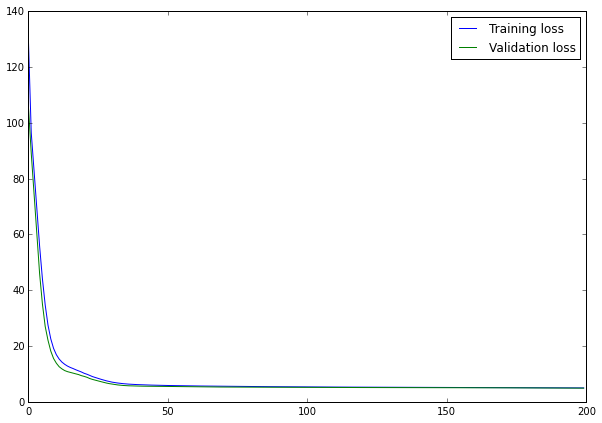

In [13]:
plt.figure(figsize=(10,7))
plt.plot(tr_loss2, label="Training loss")
plt.plot(val_loss2, label="Validation loss")
plt.legend()
print np.min(tr_loss2)


Final position for starting position x1
[ nan  nan  nan  nan  10.   1.]
Final position for starting position x2
[  1.12265783e-01   3.14159873e+00   9.98463111e-05  -1.45991576e-06
   5.00000000e+00   5.00000000e-01]
Final position for test starting position
[-0.02978593  3.14952838 -0.09178296 -0.01643456  7.          0.6       ]


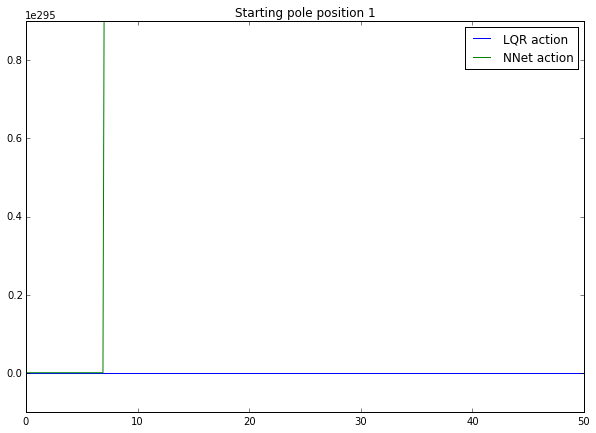

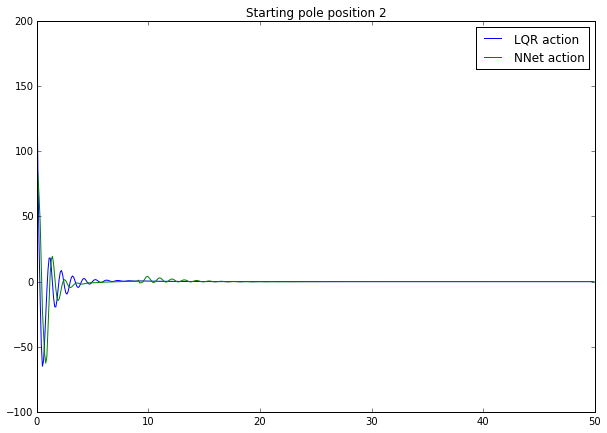

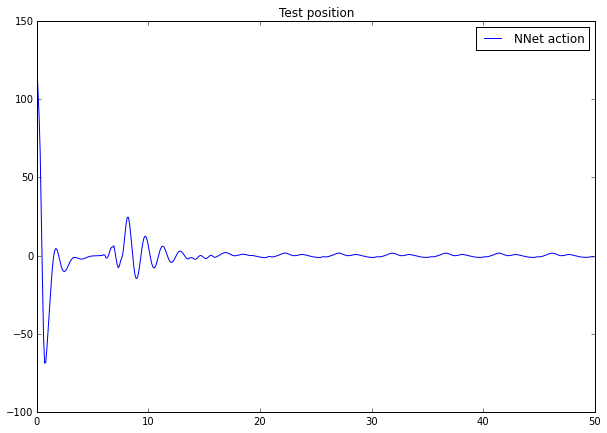

In [14]:
##########################
# TEST THE POLICY POLICY #
##########################

feed_forward = theano.function(
    inputs=[input2],
    outputs=policy2.output)

x_ref1 = np.array([0, np.pi, 0, 0, 10, 1])
x_ref2 = np.array([0, np.pi, 0, 0, 5, 0.5])

# First starting position
x_sim1 = np.zeros([6,500])
x_sim1[:,0] = x1

u_sim1 = np.zeros([500,])
u_sim1[0] = feed_forward(x_sim1[:,0].reshape([1,6]))

for t in range(499):
    x_sim1[:,t+1] = cp.sim_cartpole_ext(x_sim1[:,t], u_sim1[t], dt)
    u_sim1[t+1] = feed_forward(x_sim1[:,t+1].reshape([1,6]))

x_lqr1 = np.zeros([6,500])
x_lqr1[:,0] = x1

u_lqr1 = np.zeros([500,])
u_lqr1[0] = np.dot(K1, x_lqr1[:,0] - x_ref)
for t in range(499):
    x_lqr1[:,t+1] = cp.sim_cartpole_ext(x_lqr1[:,t], u_lqr1[t], dt)
    u_lqr1[t+1] = np.dot(K1, x_lqr1[:,t] - x_ref)

# Second starting position
x_sim2 = np.zeros([6,500])
x_sim2[:,0] = x4

u_sim2 = np.zeros([500,])
u_sim2[0] = feed_forward(x_sim2[:,0].reshape([1,6]))

for t in range(499):
    x_sim2[:,t+1] = cp.sim_cartpole_ext(x_sim2[:,t], u_sim2[t], dt)
    u_sim2[t+1] = feed_forward(x_sim2[:,t+1].reshape([1,6]))

x_lqr2 = np.zeros([6,500])
x_lqr2[:,0] = x4

u_lqr2 = np.zeros([500,])
u_lqr2[0] = np.dot(K1, x_lqr2[:,0] - x_ref2)
for t in range(499):
    x_lqr2[:,t+1] = cp.sim_cartpole_ext(x_lqr2[:,t], u_lqr2[t], dt)
    u_lqr2[t+1] = np.dot(K2, x_lqr2[:,t] - x_ref2)

# Test starting position
x_sim3 = np.zeros([6,500])
x_sim3[:,0] = np.array([0, np.pi - np.pi/4, 0, 0, 7, 0.6])

u_sim3 = np.zeros([500,])
u_sim3[0] = feed_forward(x_sim3[:,0].reshape([1,6]))

for t in range(499):
    x_sim3[:,t+1] = cp.sim_cartpole_ext(x_sim3[:,t], u_sim3[t], dt)
    u_sim3[t+1] = feed_forward(x_sim3[:,t+1].reshape([1,6]))

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr1.flatten(), label="LQR action")
plt.plot(tt, u_sim1.flatten(), label="NNet action")
plt.title("Starting pole position 1")
plt.legend()

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr2.flatten(), label="LQR action")
plt.plot(tt, u_sim2.flatten(), label="NNet action")
plt.title("Starting pole position 2")
plt.legend()

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_sim3.flatten(), label="NNet action")
plt.title("Test position")
plt.legend()

print "Final position for starting position x1"
print x_sim1[:,-1]
print "Final position for starting position x2"
print x_sim2[:,-1]
print "Final position for test starting position"
print x_sim3[:,-1]


In [15]:
xref4 = np.array([0,np.pi,0,0,15,1.5])
A4, B4, c4 = cp.linearize_cartpole_ext(xref4, uref, dt, eps)
K4, P4, Quu4 = cp.lqr_infinite_horizon(A4, B4, Q, R)

xref5 = np.array([0,np.pi,0,0,20,2.0])
A5, B5, c5 = cp.linearize_cartpole_ext(xref5, uref, dt, eps)
K5, P5, Quu5 = cp.lqr_infinite_horizon(A5, B5, Q, R)

x7 = np.array([0, np.pi - np.pi/4, 0, 0, 15, 1.5])
x8 = np.array([0, np.pi + np.pi/4, 0, 0, 15, 1.5])

x9 = np.array([0, np.pi - np.pi/4, 0, 0, 20, 2.0])
x10 = np.array([0, np.pi + np.pi/4, 0, 0, 20, 2.0])


tr_x, tr_u, val_x, val_u, te_x, te_u = cp.gen_train_data(
    [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10], 
    [K1, K1, K2, K2, K3, K3, K4, K4, K5, K5], 
    [Quu1, Quu1, Quu2, Quu2, Quu3, Quu3, Quu4, Quu4, Quu5, Quu5], 
    num_traj=20, traj_size=500)


In [22]:
####################
# TRAIN BASIC NNET #
####################

input3, policy3, tr_loss3, val_loss3, test_loss3 = nnet.train_NN(
    tr_x, tr_u, val_x, val_u, te_x, te_u, # Training, validiation, and test data
    n_layers=1, n_hidden=25, # Nnet parameters
    learning_rule='rmsprop', learning_rate=0.005, L1_reg=0., L2_reg=0.00001, batch_size=50, rho=0.9, #SGD parameters
    n_epochs=1000, print_interval=5, random_order=True # Training parameters
)

... building the model
... training
epoch 5, minibatch 2000/2000, validation error 173.541026, test error of best model 173.967018
epoch 10, minibatch 2000/2000, validation error 83.874521, test error of best model 93.235520
epoch 15, minibatch 2000/2000, validation error 51.391425, test error of best model 67.768607
epoch 20, minibatch 2000/2000, validation error 39.556078, test error of best model 59.906113
epoch 25, minibatch 2000/2000, validation error 34.481543, test error of best model 57.017930
epoch 30, minibatch 2000/2000, validation error 32.333352, test error of best model 56.196232
epoch 35, minibatch 2000/2000, validation error 28.707644, test error of best model 52.399907
epoch 40, minibatch 2000/2000, validation error 28.065036, test error of best model 50.880151
epoch 45, minibatch 2000/2000, validation error 28.207521, test error of best model 50.880151
epoch 50, minibatch 2000/2000, validation error 24.911166, test error of best model 49.246741
epoch 55, minibatch 200

7.40282845785


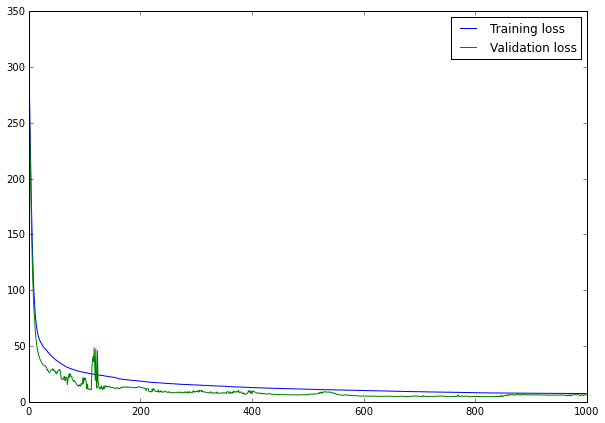

In [23]:
plt.figure(figsize=(10,7))
plt.plot(tr_loss3, label="Training loss")
plt.plot(val_loss3, label="Validation loss")
plt.legend()
print np.min(tr_loss3)

Final position for starting position x1
[  1.90379734e+00   3.14159508e+00   3.79154275e-04   5.01138359e-06
   2.00000000e+01   2.00000000e+00]
Final position for starting position x2
[  5.63757372e-01   3.14159345e+00   3.55508243e-05  -3.03353063e-07
   5.00000000e+00   5.00000000e-01]
Final position for test starting position
[  3.65512958e+00   3.14263181e+00  -2.13405425e-02   8.17296398e-04
   2.00000000e+01   2.00000000e+00]


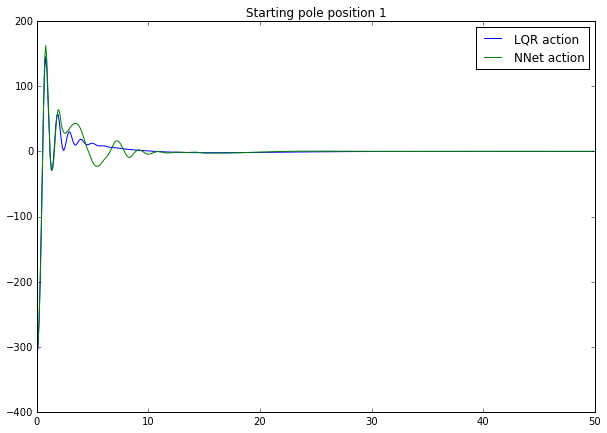

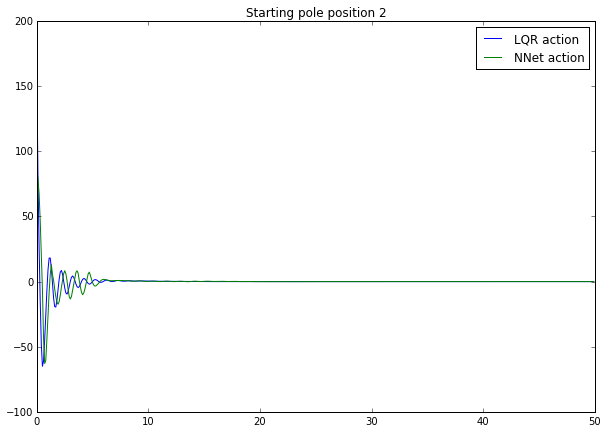

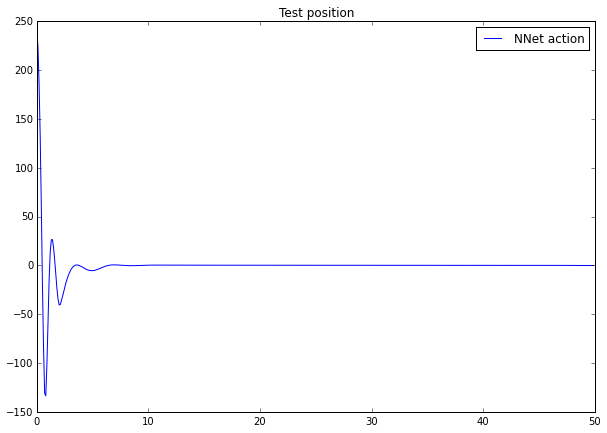

In [27]:
##########################
# TEST THE POLICY POLICY #
##########################

feed_forward = theano.function(
    inputs=[input3],
    outputs=policy3.output)

x_ref1 = np.array([0, np.pi, 0, 0, 20, 2.])
x_ref2 = np.array([0, np.pi, 0, 0, 5, 0.5])

# First starting position
x_sim1 = np.zeros([6,500])
x_sim1[:,0] = x10

u_sim1 = np.zeros([500,])
u_sim1[0] = feed_forward(x_sim1[:,0].reshape([1,6]))

for t in range(499):
    x_sim1[:,t+1] = cp.sim_cartpole_ext(x_sim1[:,t], u_sim1[t], dt)
    u_sim1[t+1] = feed_forward(x_sim1[:,t+1].reshape([1,6]))

x_lqr1 = np.zeros([6,500])
x_lqr1[:,0] = x10

u_lqr1 = np.zeros([500,])
u_lqr1[0] = np.dot(K5, x_lqr1[:,0] - x_ref1)
for t in range(499):
    x_lqr1[:,t+1] = cp.sim_cartpole_ext(x_lqr1[:,t], u_lqr1[t], dt)
    u_lqr1[t+1] = np.dot(K5, x_lqr1[:,t] - x_ref1)

# Second starting position
x_sim2 = np.zeros([6,500])
x_sim2[:,0] = x3

u_sim2 = np.zeros([500,])
u_sim2[0] = feed_forward(x_sim2[:,0].reshape([1,6]))

for t in range(499):
    x_sim2[:,t+1] = cp.sim_cartpole_ext(x_sim2[:,t], u_sim2[t], dt)
    u_sim2[t+1] = feed_forward(x_sim2[:,t+1].reshape([1,6]))

x_lqr2 = np.zeros([6,500])
x_lqr2[:,0] = x3

u_lqr2 = np.zeros([500,])
u_lqr2[0] = np.dot(K1, x_lqr2[:,0] - x_ref2)
for t in range(499):
    x_lqr2[:,t+1] = cp.sim_cartpole_ext(x_lqr2[:,t], u_lqr2[t], dt)
    u_lqr2[t+1] = np.dot(K2, x_lqr2[:,t] - x_ref2)

# Test position
x_sim3 = np.zeros([6,500])
x_sim3[:,0] = np.array([0, np.pi - np.pi/5, 0, 0, 20, 2.0])

u_sim3 = np.zeros([500,])
u_sim3[0] = feed_forward(x_sim3[:,0].reshape([1,6]))

for t in range(499):
    x_sim3[:,t+1] = cp.sim_cartpole_ext(x_sim3[:,t], u_sim3[t], dt)
    u_sim3[t+1] = feed_forward(x_sim3[:,t+1].reshape([1,6]))

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr1.flatten(), label="LQR action")
plt.plot(tt, u_sim1.flatten(), label="NNet action")
plt.title("Starting pole position 1")
plt.legend()

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr2.flatten(), label="LQR action")
plt.plot(tt, u_sim2.flatten(), label="NNet action")
plt.title("Starting pole position 2")
plt.legend()

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_sim3.flatten(), label="NNet action")
plt.title("Test position")
plt.legend()

print "Final position for starting position x1"
print x_sim1[:,-1]
print "Final position for starting position x2"
print x_sim2[:,-1]
print "Final position for test starting position"
print x_sim3[:,-1]


In [59]:
xref1

array([  0.        ,   3.14159265,   0.        ,   0.        ,
        10.        ,   1.        ])

In [46]:
for i in np.arange(1,31,1):
    out = "%i: " % i
    for j in [np.pi - np.pi/4, np.pi - np.pi/5, np.pi - np.pi/6, 
              np.pi + np.pi/6, np.pi + np.pi/5, np.pi + np.pi/4]:
        x_sim4 = np.zeros([6,500])
        x_sim4[:,0] = np.array([0, np.pi - np.pi/5, 0, 0, i, i/10.])

        u_sim4 = np.zeros([500,])
        u_sim4[0] = feed_forward(x_sim4[:,0].reshape([1,6]))

        for t in range(499):
            x_sim4[:,t+1] = cp.sim_cartpole_ext(x_sim4[:,t], u_sim4[t], dt)
            u_sim4[t+1] = feed_forward(x_sim4[:,t+1].reshape([1,6]))
        out = out+ x_sim4[1,-1]
        out =  "     "
    print out

1: 2.89299507745     2.89325658065     3.33672396594     3.3370777     nan     nan     
2: 3.01119307102     3.05338930806     3.03237116306     3.22356483002     3.22356483002     3.25704534041     
3: 3.03191509299     3.26850644406     3.14143779106     3.23356520337     3.2589156958     2.99793563862     
4: 3.23451953919     3.23892548518     3.07637463657     3.04934655371     3.04200043265     3.04934652769     
5: 3.14159344575     3.14159383478     3.14159396314     3.14159446746     3.14159358169     3.14159328744     
6: 3.14923111854     3.27211733746     3.2518047412     3.05398335402     2.9965589963     3.10711853808     
7: 3.29238909884     3.09695165672     3.03139037294     2.97450128901     3.27310906224     3.157600078     
8: 3.30163161466     3.22736170945     3.280029842     3.31493070287     3.02771884238     3.09666211207     
9: 2.97570177964     2.97440347397     2.97727130522     2.96893312483     3.32451611641     3.10525748598     
10: 3.27842800633     3

In [72]:
isinstance(np.nan, np.nan)

TypeError: isinstance() arg 2 must be a class, type, or tuple of classes and types

In [70]:
for i in np.arange(1,22,1):
    out = "%i: " % i
    for j in np.arange(-0.90, 0.95, 0.05): # percentage error in mass estimation
        i_adj = (1+j)*i
        x_sim4 = np.zeros([6,500])
        x_sim4_real = np.zeros([6,500])
        x_sim4[:,0] = np.array([0, np.pi - np.pi/4, 0, 0, i, i/10.])
        x_sim4_real[:,0] = np.array(x_sim4[:,0])
        x_sim4_real[-2,0] = i_adj
        x_sim4_real[-1,0] = i_adj/10.

        u_sim4 = np.zeros([500,])
        u_sim4[0] = feed_forward(x_sim4[:,0].reshape([1,6]))

        for t in range(499):
            x_sim4_real[:,t+1] = cp.sim_cartpole_ext(x_sim4_real[:,t], u_sim4[t], dt)
            x_sim4[:,t+1] = np.array([x_sim4_real[:,t+1]])
            x_sim4[-2,t+1] = i
            x_sim4[-1,t+1] = i/10.
            u_sim4[t+1] = feed_forward(x_sim4[:,t+1].reshape([1,6]))
        out = out + str(round(x_sim4[1,-1]))
        out = out+ " "
    print out

1: nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 
2: nan nan nan nan nan nan nan nan 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 
3: nan nan nan nan nan 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 2.0 3.0 3.0 4.0 3.0 
4: nan nan nan nan 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 4.0 3.0 3.0 nan nan nan nan nan nan 
5: nan nan nan 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 nan nan nan nan 
6: nan nan nan nan 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 257.0 3.0 3.0 nan nan nan nan nan 
7: nan nan nan 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0

In [65]:
for j in np.arange(-0.95, 0.80, 0.05): # percentage error in mass estimation
    real_mass = (1+j)*10
    x_sim4 = np.zeros([6,500])
    x_sim4[:,0] = np.array([0, np.pi + np.pi/4, 0, 0, real_mass, real_mass/10.])

    u_sim4 = np.zeros([500,])
    u_sim4[0] = feed_forward(x_sim4[:,0].reshape([1,6]))

    for t in range(499):
        x_sim4[:,t+1] = cp.sim_cartpole_ext(x_sim4[:,t], u_sim4[t], dt)
        u_sim4[t+1] = np.dot(K1, x_sim4[:,t+1] - xref1)
    print "%f: %f" % (j, round(x_sim4[1,-1],2))

-0.950000: nan
-0.900000: nan
-0.850000: nan
-0.800000: nan
-0.750000: 2.130000
-0.700000: 2.600000
-0.650000: 3.140000
-0.600000: 3.140000
-0.550000: 3.140000
-0.500000: 3.140000
-0.450000: 3.140000
-0.400000: 3.140000
-0.350000: 3.140000
-0.300000: 3.140000
-0.250000: 3.140000
-0.200000: 3.140000
-0.150000: 3.140000
-0.100000: 3.140000
-0.050000: 3.140000
0.000000: 3.140000
0.050000: 3.140000
0.100000: 3.140000
0.150000: 3.140000
0.200000: 3.140000
0.250000: 3.140000
0.300000: 3.140000
0.350000: 3.140000
0.400000: 3.140000
0.450000: nan
0.500000: nan
0.550000: nan
0.600000: nan
0.650000: nan
0.700000: nan
0.750000: nan


In [56]:
K1

array([[   0.66825241, -198.9260786 ,    3.6267969 ,  -43.03913635,
          -0.        ,   -0.        ]])

In [48]:
np.arange(0.05, 0.5, 0.05)

array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45])

In [47]:
# Save that controller
with open('crobot_controller1.pickle', 'wb') as output_file:
    pickle.dump(policy3, output_file)

In [110]:
xref6 = np.array([0,np.pi,0,0,25,2.5])
A6, B6, c6 = cp.linearize_cartpole_ext(xref6, uref, dt, eps)
K6, P6, Quu6 = cp.lqr_infinite_horizon(A6, B6, Q, R)

xref7 = np.array([0,np.pi,0,0,30,3.0])
A7, B7, c7 = cp.linearize_cartpole_ext(xref7, uref, dt, eps)
K7, P7, Quu7 = cp.lqr_infinite_horizon(A7, B7, Q, R)

xref8 = np.array([0,np.pi,0,0,40,4.0])
A8, B8, c8 = cp.linearize_cartpole_ext(xref8, uref, dt, eps)
K8, P8, Quu8 = cp.lqr_infinite_horizon(A8, B8, Q, R)

xref9 = np.array([0,np.pi,0,0,50,5.0])
A9, B9, c9 = cp.linearize_cartpole_ext(xref9, uref, dt, eps)
K9, P9, Quu9 = cp.lqr_infinite_horizon(A9, B9, Q, R)

xref10 = np.array([0,np.pi,0,0,60,6.0])
A10, B10, c10 = cp.linearize_cartpole_ext(xref10, uref, dt, eps)
K10, P10, Quu10 = cp.lqr_infinite_horizon(A10, B10, Q, R)

x11 = np.array([0, np.pi - np.pi/4, 0, 0, 25, 2.5])
x12 = np.array([0, np.pi + np.pi/4, 0, 0, 25, 2.5])

x13 = np.array([0, np.pi - np.pi/4, 0, 0, 30, 3.0])
x14 = np.array([0, np.pi + np.pi/4, 0, 0, 30, 3.0])

x15 = np.array([0, np.pi - np.pi/4, 0, 0, 40, 4.0])
x16 = np.array([0, np.pi + np.pi/4, 0, 0, 40, 4.0])

x17 = np.array([0, np.pi - np.pi/4, 0, 0, 50, 5.0])
x18 = np.array([0, np.pi + np.pi/4, 0, 0, 50, 5.0])

x19 = np.array([0, np.pi - np.pi/4, 0, 0, 60, 6.0])
x20 = np.array([0, np.pi + np.pi/4, 0, 0, 60, 6.0])

In [109]:
x20

array([ 0.        ,  3.92699082,  0.        ,  0.        ,  6.        ,  6.        ])

In [111]:
tr_x, tr_u, val_x, val_u, te_x, te_u = cp.gen_train_data(
    [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20], 
    [K1, K1, K2, K2, K3, K3, K4, K4, K5, K5, K6, K6, K7, K7, K8, K8, K9, K9, K10, K10], 
    [Quu1, Quu1, Quu2, Quu2, Quu3, Quu3, Quu4, Quu4, Quu5, Quu5, 
     Quu6, Quu6, Quu7, Quu7, Quu8, Quu8, Quu9, Quu9, Quu10, Quu10], 
    num_traj=20, traj_size=500)


In [ ]:
input4, policy4, tr_loss4, val_loss4, test_loss4 = nnet.train_NN(
    tr_x, tr_u, val_x, val_u, te_x, te_u, # Training, validiation, and test data
    n_layers=1, n_hidden=50, # Nnet parameters
    learning_rule='rmsprop', learning_rate=0.001, L1_reg=0., L2_reg=0.00001, batch_size=25, rho=0.95, #SGD parameters
    n_epochs=5000, print_interval=50, random_order=True # Training parameters
)

... building the model
... training

In [ ]:
lr_table = {0.01:[2695, 2648, 7302], 0.02:[5048, 1647, 2592], 0.001: [2835,7379, 4456], 
 0.002: [7775, 6988, 3149], 0.005: [3053, 2265, 12458], 0.0001:[152182, 142120], 0.0005:[50889, 66356]}

L2_reg_table = {0.01:[3337, 3967, 2544], 0.001:[6895, 3080, 6626], 0.0001:[1761, 5542, 1910], 
                0.00001:[6228, 6129, 3412]}

batch_size_table = {10:[958, 848, 2773], 5:[1509], 20:[2814, 3268, 1170], 50:[2213, 4026, 1910], 200: [6070, 7917, 4974]}

rho_table = {0.8: [2207, 3103, 7137], 0.95:[4073, 2084, 2011], 0.99:[1382, 3074, 3260], 0.999:[7028, 1465, 4769]}